In [1]:
library(causalTree)

# set global parameters
minsize.temp = 40
split.Bucket.temp = T
bucketNum.temp = 10
bucketMax.temp = 100

# Do causal tree estimation
split.Rule.temp = "CT" #CT
cv.option.temp = "CT" #CT
split.Honest.temp = T
cv.Honest.temp = T
split.alpha.temp = .5
cv.alpha.temp = .5
xvalsize = 10
cp.temp = 0

get_causal_tree <- function(forml, dataTrain){
    if(.Platform$OS.type == "unix"){
        sink("/dev/null");
    }
    else{
        sink("nul");
    }

    tree <- causalTree(as.formula(forml), data = dataTrain, treatment = dataTrain$w,
                     split.Rule=split.Rule.temp, split.Honest=T, split.Bucket=split.Bucket.temp, bucketNum = bucketNum.temp, 
                     bucketMax = bucketMax.temp, cv.option=cv.option.temp, cv.Honest=cv.Honest.temp, minsize = minsize.temp, 
                     split.alpha = split.alpha.temp, cv.alpha = cv.alpha.temp, xval=xvalsize, cp = cp.temp)
    sink();
    tree
}

Loading required package: rpart
Loading required package: rpart.plot
Loading required package: data.table


In [2]:
remove_na <- function(data, vec){
    for(v in vec){
        tmp <- data[[v]]
        data <- data[!is.na(tmp),]
    }
    data
}

In [3]:
get_treatment_effect <- function(data_, indices, outcome_var){
    relevant_data <- data_[indices,]

    # the block probabilities can be introduced here to normalize things
    # will need to supply them based on some measure
    treatment_values <- relevant_data[relevant_data$w == 1, outcome_var]
    control_values <- relevant_data[relevant_data$w == 0, outcome_var]
    mean(treatment_values) - mean(control_values)
}

In [4]:
get_model <- function(data, fml, outcome_var, frac_tr, frac_e, B, precision=4, adaptive_sampling=FALSE){

    N <- nrow(data)
    ntr <- frac_tr*N
    ne <- frac_e*N
    nb <- ntr + ne

    trees <- list()
    treatments <- list()
    adaptive_samples <- matrix(1, nrow=B, ncol=nrow(data))

    for(jj in 1:B){
        if(jj %% 50 == 0){
            cat(sprintf("Constructing tree %d\n", jj))
        }

        sub_sample <- sample(N, nb)

        if(adaptive_sampling){
            adaptive_samples[jj, sub_sample] <- 0    
        }

        train_indices <- sample(sub_sample, ntr)
        estimation_indices <- setdiff(sub_sample, train_indices)
        sampled_tr <- data[train_indices, ]
        sampled_e <- data[estimation_indices, ]
        cf <- get_causal_tree(fml, sampled_tr)

        predictions <- predict(cf, newdata=sampled_e)
        predictions <- sapply(predictions, function(t){as.character(round(t, precision))})
        all_unique <- unique(predictions)

        l <- list()
        for(i in all_unique){
            l[[i]] <- vector()
        }

        count = 1
        for(i in predictions){
            l[[i]] <- c(l[[i]], count)
            count <- count + 1
        }

        treatment_effects <- list()
        for(i in names(l)){
            treatment_effects[[i]] <- get_treatment_effect(sampled_e, l[[i]], outcome_var)
        }

        trees[[jj]] <- cf
        treatments[[jj]] <- treatment_effects
    }
    list(trees=trees, treatments=treatments, adaptive_samples=adaptive_samples)
}

In [5]:
make_prediction <- function(model, newdata, precision=4){
    predictions <- vector(length=nrow(newdata))
    trees <- model$trees
    treatments <- model$treatments
    adaptive_samples <- model$adaptive_samples
    B <- length(trees)

    for(i in 1:B){
        cf <- trees[[i]]
        treatment <- treatments[[i]]
        all_predictions <- predict(cf, new_data=newdata)
        all_predictions <- sapply(all_predictions, function(t){v <- as.character(round(t, precision)); as.numeric(treatment[[v]])})
        predictions <- predictions + adaptive_samples[i]*all_predictions
    }

    predictions/colSums(adaptive_samples)
}

In [6]:
do_regression <- function(data, treatment_effects, outcome_var, features){
    threshold <- mean(treatment_effects)
    positive_indices <- treatment_effects > threshold
    negative_indices <- !positive_indices
    positive_data <- data[positive_indices, ]
    negative_data <- data[negative_indices, ]

    modified_data <- cbind(data, positive=as.numeric(positive_indices), negative=as.numeric(negative_indices))
    fml1 <- paste(outcome_var, " ~ 0 + w + w:positive + ", paste(features, collapse=" + "))
    fml2 <- paste(outcome_var, " ~ 0 + w + w:negative + ", paste(features, collapse=" + "))
    h1 <- lm(fml1, data=modified_data)
    h2 <- lm(fml2, data=modified_data)
    list(positive=h1, negative=h2)
}

In [7]:
library(foreign)

features <- c("gender", "race", "g1surban", "g1freelunch", "g1tgen", "g1trace", "w")

data_source <- "kindergarten.dta"
data <- read.dta(data_source)
data <- data[data$flagsg1 == "yes",]
data$y <- (data$g1tlistss + data$g1treadss + data$g1tmathss + data$g1wordskillss)
data$w <- sapply(as.character(data$g1classtype), function(x){if(x == 'SMALL CLASS') return (1) else return (0)})
                                                                     
data <- remove_na(data, c("y", "w", features))

In [8]:
scores <- list()
interaction <- list()
beta <- 5
feat <- head(features, -1)

for(f in feat){
    l1 <- list()
    l2 <- list()
    c <- sample(5:10, 1)

    for(level in levels(data[[f]])){
        l1[[level]] <- sample(seq(1, 10), 1)
        l2[[level]] <- l1[[level]]/c
    }
    scores[[f]] <- l1
    interaction[[f]] <- l2
}

In [11]:
get_scores <- function(row){
#     feat <- head(features, -1)
    feat <- c("gender", "race", "g1surban", "g1freelunch", "g1tgen", "g1trace")

    x <- 0
    for(f in feat){
        x <- x + scores[[f]][[row[[f]]]]
    }
    
    x <- x + as.numeric(row[["w"]])*(beta + rnorm(1, sd=1))
    
#     # interaction terms
#     pairs <- list(c("gender", "race"), c("race", "g1freelunch"), c("gender", "g1freelunch"))
    
#     for(pair in pairs){
#         x <- x + scores[[pair[1]]][[row[[pair[1]]]]] * scores[[pair[2]]][[row[[pair[2]]]]]/(interaction[[pair[1]]][[row[[pair[1]]]]]*interaction[[pair[2]]][[row[[pair[2]]]]])
#     }

    x
}

In [12]:
data$y_tilde <- apply(data, 1, get_scores)
data$noise <- sample(20:30, nrow(data), replace=TRUE)

In [44]:
features <- c("gender", "race", "g1surban", "g1freelunch", "g1tgen", "g1trace")
outcome_var <- "y_tilde"

out <- paste(features, collapse="+")
causal_fml <- paste(outcome_var, " ~ ", out, sep="")
model <- get_model(data, causal_fml, outcome_var, 0.1, 0.1, 100)

Constructing tree 50
Constructing tree 100


In [45]:
treatment_effects <- make_prediction(model, data)
h <- do_regression(data, treatment_effects, outcome_var, features)

h

$positive

Call:
lm(formula = fml1, data = modified_data)

Coefficients:
                        w                 gendermale  
                  4.94733                   28.12160  
             genderfemale                  raceblack  
                 31.09582                    6.02493  
                raceasian                  raceother  
                 -0.12886                    7.79505  
         g1surbansuburban              g1surbanrural  
                 -6.96884                   -4.02214  
            g1surbanurban  g1freelunchNON-FREE LUNCH  
                 -3.01951                   -0.03627  
             g1tgenfemale               g1traceblack  
                  0.91895                   -2.04124  
               w:positive  
                 -0.01269  


$negative

Call:
lm(formula = fml2, data = modified_data)

Coefficients:
                        w                 gendermale  
                  4.93464                   28.12160  
             genderfemale 

[1] 0.5366947

,-1,1,MeanDecreaseAccuracy,MeanDecreaseGini
gender,7.387818,9.677185,10.6650400,5.077742
race,4.676626,-3.842056,1.8064521,7.122670
g1surban,2.156660,-1.711860,0.9271855,8.642283
g1freelunch,-7.787220,5.550970,-4.5973383,3.661430
g1tgen,-1.751659,2.234442,0.2855560,2.185464
g1trace,2.312965,0.619978,6.3721658,4.406632


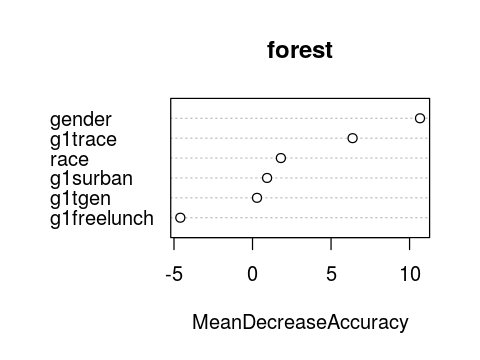

In [46]:
library(randomForest)

tau <- treatment_effects - mean(treatment_effects)
labels <- factor(2*as.numeric(tau > 0) - 1)

rhs <- paste(features, collapse="+")
forml <- paste("labels ~", rhs)

forest <- randomForest(as.formula(forml), data=data.frame(data, labels=labels), importance=TRUE)

sum(predict(forest, newdata=data) == labels)/length(labels)
# sqrt(sum((predict(forest, newdata=data) - data$y_tilde)^2)/length(labels))

importance(forest)
options(repr.plot.width=4, repr.plot.height=3)
varImpPlot(forest, type=1)

In [43]:
table(data[,"race"])
table(data[,"g1freelunch"])


          white           black           asian        hispanic NATIVE AMERICAN 
           2466            1093               8               0               0 
          other 
              3 


    FREE LUNCH NON-FREE LUNCH 
          1594           1976 

In [47]:
forml <- paste("y_tilde ~ 0+labels+w+labels:w+", paste(features, collapse="+"))
reg <- lm(as.formula(forml), data=data.frame(data, labels=as.numeric(labels)))
reg
forml

library(caret)
varImp(reg)


Call:
lm(formula = as.formula(forml), data = data.frame(data, labels = as.numeric(labels)))

Coefficients:
                   labels                          w  
                 0.002616                   4.963962  
               gendermale               genderfemale  
                28.117524                  31.091695  
                raceblack                  raceasian  
                 6.025063                  -0.128493  
                raceother           g1surbansuburban  
                 7.794200                  -6.968722  
            g1surbanrural              g1surbanurban  
                -4.022010                  -3.019535  
g1freelunchNON-FREE LUNCH               g1tgenfemale  
                -0.036271                   0.918996  
             g1traceblack                   labels:w  
                -2.041280                  -0.015311  


[1] "y_tilde ~ 0+labels+w+labels:w+ gender+race+g1surban+g1freelunch+g1tgen+g1trace"

,Overall
w,76.0591859
gendermale,196.3456293
genderfemale,216.6773922
raceblack,173.8978843
raceasian,0.6156675
raceother,22.8961298
g1surbansuburban,178.0464309
g1surbanrural,97.1857648
g1surbanurban,59.5476129
g1freelunchNON-FREE LUNCH,1.5670757


In [15]:
class1 <- data[tau > 0, ]
class2 <- data[tau <= 0, ]

# imp_features <- rownames(importance(forest))
l_ <- list()

for(f in features){
    t1 <- table(class1[, f])
    t2 <- table(class2[, f])
    l_[[f]] <- cbind(t1, t1/(t1+t2), t2, t2/(t1+t2))
}

l_

,t1,,t2,
male,868,0.4857303,919,0.5142697
female,872,0.4890634,911,0.5109366
,t1,,t2,
white,1214,0.4922952,1252,0.5077048
black,521,0.4766697,572,0.5233303
asian,4,0.5000000,4,0.5000000
hispanic,0,NaN,0,NaN
NATIVE AMERICAN,0,NaN,0,NaN
other,1,0.3333333,2,0.6666667
,t1,,t2,
